Found 613 files belonging to 4 classes.
Found 72 files belonging to 4 classes.
Found 315 files belonging to 4 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4115 - loss: 1.8734
Epoch 1: val_loss improved from inf to 0.86981, saving model to chestmodel_resnet50.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 169s 7s/step - accuracy: 0.4149 - loss: 1.8507 - val_accuracy: 0.6111 - val_loss: 0.8698
Epoch 2/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6307 - loss: 0.8113
Epoch 2: val_loss improved from 0.86981 to 0.78676, saving model to chestmodel_resnet50.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 151s 7s/step - accuracy: 0.6303 - loss: 0.8120 - val_accuracy: 0.5833 - val_loss: 0.7868
Epoch 3/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6323 - loss: 0.7978
Epoch 3: val_loss did not improve from 0.78676
20/20 ━━━━━━━━━━━━━━━━━━━━ 189s 7s/step - accuracy: 0.6330 - loss: 0.7955 - val_accuracy: 0.6111 - val_loss: 0.7980
Ep

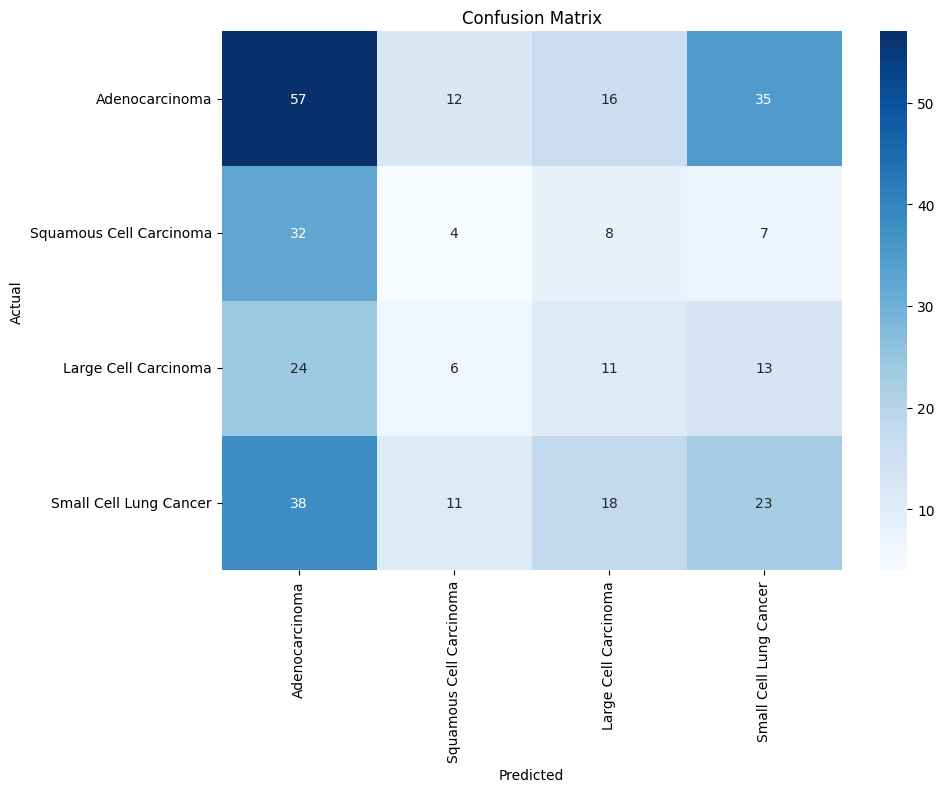

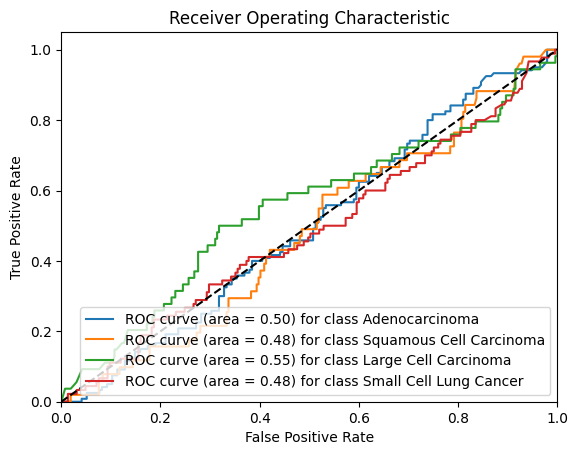

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


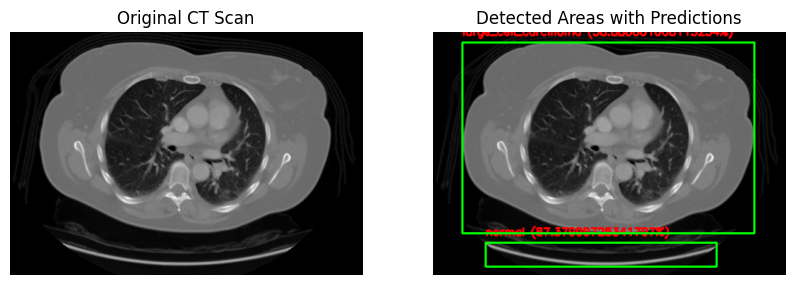

Detected area 1: normal with confidence 87.37999725341797%
Detected area 2: large_cell_carcinoma with confidence 38.880001068115234%
Final prediction result (considering 85.0% model accuracy): normal with confidence 87.37999725341797%
No cancer detected: normal with confidence 87.37999725341797% (model accuracy: 85.0%)
The image is classified as: normal with confidence 87.37999725341797%


In [1]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers, optimizers
import tensorflow as tf
from tensorflow.keras.applications import ResNet50  # Changed to ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import os
import cv2

# Data paths and constants
train_path = "/content/drive/MyDrive/Data/train"
valid_path = "/content/drive/MyDrive/Data/valid"
test_path = "/content/drive/MyDrive/Data/test"

IMAGE_SIZE = 224
N_CLASSES = 4
BATCH_SIZE = 32
CHANNELS = 1

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=10,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    dtype='float32'
)
train_generator = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="grayscale"
)

valid_datagen = ImageDataGenerator(dtype='float32', rescale=1./255.)
valid_generator = tf.keras.preprocessing.image_dataset_from_directory(
    valid_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="grayscale"
)

test_datagen = ImageDataGenerator(dtype='float32', rescale=1.0/255.0)
test_generator = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="grayscale"
)

test_class_names = test_generator.class_names

# Data augmentation and preprocessing
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])

data_augmentation = Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

# Convert grayscale to RGB function
def convert_to_rgb(images):
    return tf.image.grayscale_to_rgb(images) if images.shape[-1] == 1 else images

# Build ResNet50 model
def build_resnet_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), n_classes=N_CLASSES):
    # Load pre-trained ResNet50
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    # Define input
    inputs = tf.keras.Input(shape=input_shape)

    # Pass input through ResNet50
    x = base_model(inputs, training=False)

    # Add custom top layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(n_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs, outputs)
    return model

# Build and compile the model
model = build_resnet_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpointer = ModelCheckpoint('chestmodel_resnet50.keras', verbose=1, save_best_only=True)  # Updated filename
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(
    train_generator.map(lambda x, y: (convert_to_rgb(x), y)),
    epochs=25,
    validation_data=valid_generator.map(lambda x, y: (convert_to_rgb(x), y)),
    callbacks=[checkpointer, early_stopping]
)

# Evaluate the model
train_result = model.evaluate(train_generator.map(lambda x, y: (convert_to_rgb(x), y)))
print(f'Training Loss: {train_result[0]}, Training Accuracy: {train_result[1]}')

test_result = model.evaluate(test_generator.map(lambda x, y: (convert_to_rgb(x), y)))
print(f'Test Loss: {test_result[0]}, Test Accuracy: {test_result[1]}')

# Predictions and Evaluation
y_true = []
for _, labels in test_generator:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

y_pred = model.predict(test_generator.map(lambda x, y: (convert_to_rgb(x), y)))
y_pred_classes = np.argmax(y_pred, axis=1)

class_names = ['Adenocarcinoma', 'Squamous Cell Carcinoma', 'Large Cell Carcinoma', 'Small Cell Lung Cancer']

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC Curves
fpr = {}
tpr = {}
roc_auc = {}
for i in range(N_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(N_CLASSES):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for class %s' % (roc_auc[i], class_names[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Single image prediction function
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = convert_to_rgb(img_array)
    img_array = tf.image.resize(img_array, (IMAGE_SIZE, IMAGE_SIZE))
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = test_class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# CT Scan analysis with ResNet50
classifier = tf.keras.models.load_model('chestmodel_resnet50.keras')  # Updated filename
class_labels = ['adenocarcinoma', 'large_cell_carcinoma', 'normal', 'squamous_cell_carcinoma']



Found 315 files belonging to 4 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


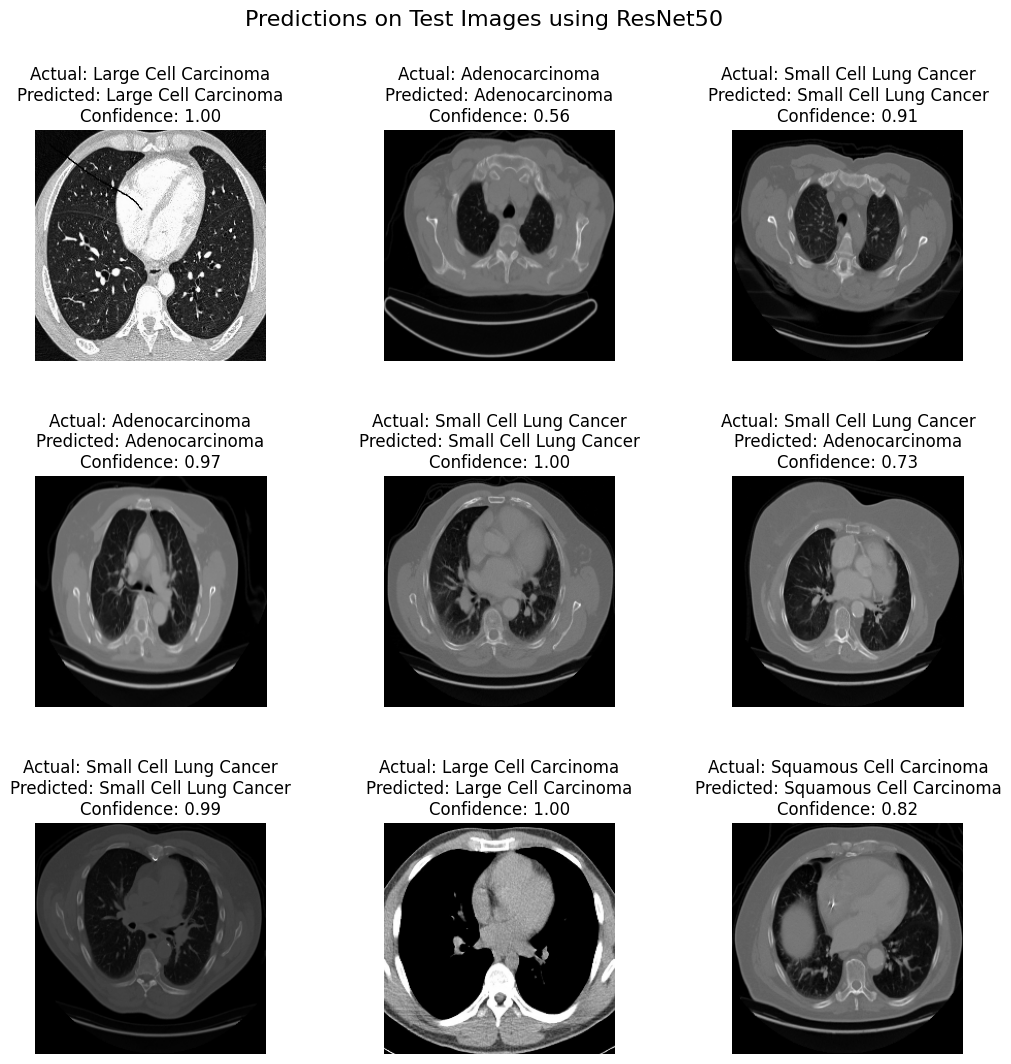

In [8]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
import numpy as np
import matplotlib.pyplot as plt

# Data paths and constants
test_path = "/content/drive/MyDrive/Data/test"
IMAGE_SIZE = 224
N_CLASSES = 4
BATCH_SIZE = 32
class_names = ['Adenocarcinoma', 'Squamous Cell Carcinoma', 'Large Cell Carcinoma', 'Small Cell Lung Cancer']

# Test data generator
test_datagen = ImageDataGenerator(dtype='float32', rescale=1.0/255.0)
test_generator = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="grayscale"
)

# Function to convert grayscale to RGB
def convert_to_rgb(images):
    return tf.image.grayscale_to_rgb(images) if images.shape[-1] == 1 else images

# Load the trained ResNet50 model
model = tf.keras.models.load_model('/content/chestmodel_resnet50.keras')

# Display predictions with confidence values
plt.figure(figsize=(12, 12))
for images, labels in test_generator.take(1):  # Take one batch from test generator
    images_rgb = convert_to_rgb(images)  # Convert grayscale to RGB for ResNet50
    y_pred = model.predict(images_rgb)    # Make predictions
    y_pred_classes = np.argmax(y_pred, axis=1)  # Get predicted class indices
    y_pred_confidence = np.max(y_pred, axis=1)  # Get confidence scores
    y_true = labels.numpy()  # Actual labels from the generator

    # Display 9 images from the batch
    for i in range(min(9, len(images))):  # Ensure we don't exceed batch size
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(f'Actual: {class_names[y_true[i]]}\n'
                  f'Predicted: {class_names[y_pred_classes[i]]}\n'
                  f'Confidence: {y_pred_confidence[i]:.2f}')
        plt.axis('off')

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle('Predictions on Test Images using ResNet50', fontsize=16)
plt.show()